# Case Studies: Case Study 1

This example shows how we obtained the results in the paper for the first case study. To start,
let us load in the packages we will need.

In [1]:
using StepwiseEQL
using CairoMakie
using EpithelialDynamics1D
using OrdinaryDiffEq

## Simulating
The first step in our procedure is to obtain the results from the cell simulation. This is
done as follows. We use the force law $F(\ell) = k(s - \ell)$.

In [2]:
force_law = (δ, p) -> p.k * (p.s - δ)
force_law_parameters = (k=50.0, s=0.2)
final_time = 5.0
damping_constant = 1.0
initial_condition = [LinRange(0, 5, 30); LinRange(25, 30, 30)] |> unique!
prob = CellProblem(;
    force_law,
    force_law_parameters,
    final_time,
    damping_constant,
    initial_condition)
sol = solve(prob, Tsit5(), saveat=LinRange(0, final_time, 50))

retcode: Success
Interpolation: 1st order linear
t: 50-element Vector{Float64}:
 0.0
 0.1020408163265306
 0.2040816326530612
 0.30612244897959184
 0.4081632653061224
 0.5102040816326531
 0.6122448979591837
 0.7142857142857142
 0.8163265306122448
 0.9183673469387755
 ⋮
 4.183673469387755
 4.285714285714286
 4.387755102040816
 4.489795918367347
 4.591836734693878
 4.6938775510204085
 4.795918367346939
 4.8979591836734695
 5.0
u: 50-element Vector{Vector{Float64}}:
 [0.0, 0.1724137931034483, 0.3448275862068966, 0.5172413793103449, 0.6896551724137931, 0.8620689655172414, 1.0344827586206897, 1.206896551724138, 1.3793103448275863, 1.5517241379310345  …  28.448275862068964, 28.620689655172413, 28.79310344827586, 28.965517241379313, 29.137931034482758, 29.310344827586206, 29.482758620689655, 29.655172413793103, 29.827586206896555, 30.0]
 [0.0, 0.17241379310349564, 0.3448275862072093, 0.5172413793123272, 0.6896551724254885, 0.862068965583525, 1.0344827589757786, 1.2068965535463891, 1.3793103537

## Equation learning
To now define the equation learning problem, we note that all we need to learn
is $D(q)$. The basis expansion we use is
$$
D(q) = \dfrac{\theta_1^d}{q} + \dfrac{\theta_2^d}{q^2} + \dfrac{\theta_3^d}{q^3},
$$
which we can define as follows:

In [3]:
diffusion_basis = BasisSet(
    (q, k) -> inv(q),
    (q, k) -> inv(q^2),
    (q, k) -> inv(q^3),
)

(::BasisSet{Tuple{Main.var"##19533".var"#3#6", Main.var"##19533".var"#4#7", Main.var"##19533".var"#5#8"}}) (generic function with 3 methods)

This could have also been defined using

In [4]:
diffusion_basis = PolynomialBasis(-1, -3)

(::BasisSet{Tuple{StepwiseEQL.var"#52#54"{Int64}, StepwiseEQL.var"#52#54"{Int64}, StepwiseEQL.var"#52#54"{Int64}}}) (generic function with 3 methods)

which is simpler. Next, let us obtain the results. The call to `stepwise_selection`
is simple in this case. To start, we use no pruning:

In [5]:
eql_sol = stepwise_selection(sol; diffusion_basis)

StepwiseEQL Solution.
    D(q) = θ₂ᵈ ϕ₂ᵈ(q)
┌──────┬──────────────────────┬───────┐
│ Step │   θ₁ᵈ    θ₂ᵈ     θ₃ᵈ │  Loss │
├──────┼──────────────────────┼───────┤
│    1 │ -5.97  70.73  -27.06 │   Inf │
│    2 │ -1.46  47.11    0.00 │ -4.33 │
│    3 │  0.00  43.52    0.00 │ -5.18 │
└──────┴──────────────────────┴───────┘


The coefficient for $\theta_2^d$ is not perfect. If we instead use some pruning on $q$,
we can obtain an improved result:

In [6]:
eql_sol2 = stepwise_selection(sol; diffusion_basis, threshold_tol=(q=0.1,))

StepwiseEQL Solution.
    D(q) = θ₂ᵈ ϕ₂ᵈ(q)
┌──────┬─────────────────────┬───────┐
│ Step │   θ₁ᵈ    θ₂ᵈ    θ₃ᵈ │  Loss │
├──────┼─────────────────────┼───────┤
│    1 │ -1.45  42.48  13.76 │ -4.19 │
│    2 │  0.00  37.79  19.69 │ -5.46 │
│    3 │  0.00  49.83   0.00 │ -7.97 │
└──────┴─────────────────────┴───────┘


(Note that the comma after `0.1` is necessary so that we get a `NamedTuple`, otherwise it doesn't parse as a `Tuple`. Compare:

In [7]:
threshold_tol = (q = 0.1) # same as threshold_tol = q = 0.1

0.1

In [8]:
threshold_tol = (q=0.1,)

(q = 0.1,)

This is only for `NamedTuple`s with a single element, e.g. `(a = 0.1, b = 0.2)` is fine.) We note also that if you
want the LaTeX form of these tables, for `eql_sol` you could use for example:

In [9]:
latex_table(eql_sol)

StepwiseEQL Solution.
    D(q) = θ₂ᵈ ϕ₂ᵈ(q)
\begin{tabular}{|r|rrr|r|}
  \hline
  \textbf{Step} & \textbf{$\theta_{1}^d$ } & \textbf{$\theta_{2}^d$ } & \textbf{$\theta_{3}^d$ } & \textbf{Loss} \\\hline
  1 & -5.97 & 70.73 & \color{blue}{\textbf{-27.06}} & $\infty$ \\
  2 & \color{blue}{\textbf{-1.46}} & 47.11 & 0.00 & -4.33 \\
  3 & 0.00 & 43.52 & 0.00 & -5.18 \\\hline
\end{tabular}


## Plotting
### Progression of the Diffusion Curves
Let us now examine our results. First, we see how the diffusion curve is changed at each step of our procedure,
comparing the results with pruning and without pruning.

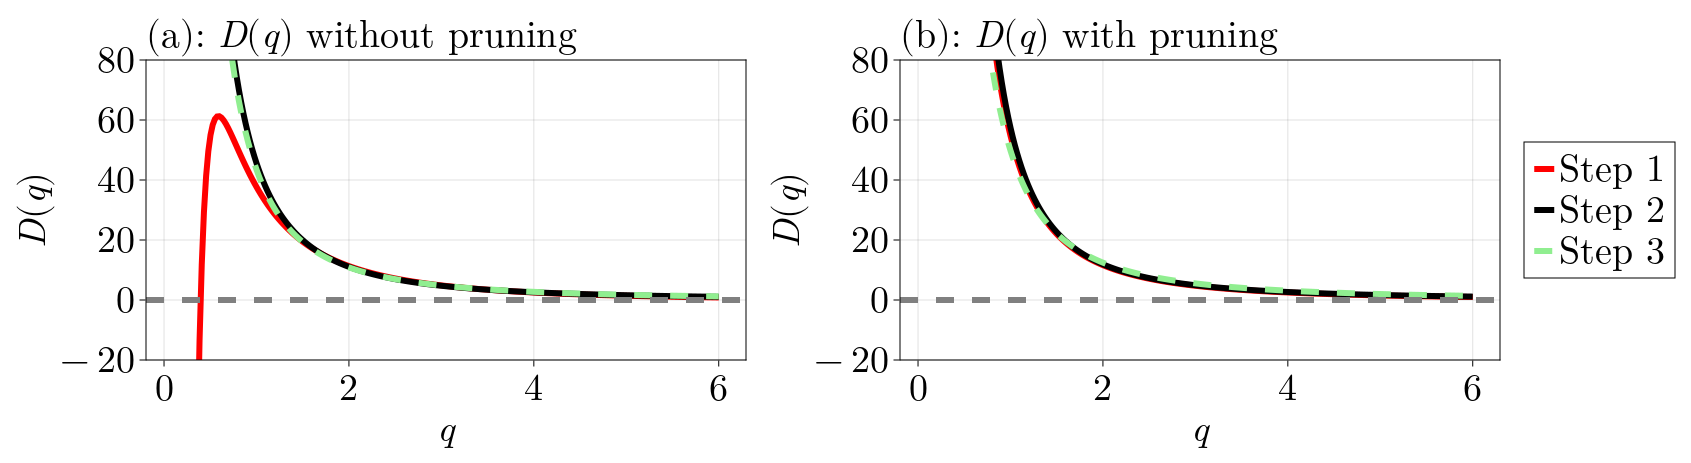

In [10]:
fig = Figure(fontsize=38)
ax1 = Axis(fig[1, 1], xlabel=L"q", ylabel=L"D(q)",
    width=600, height=300,
    title=L"(a): $D(q)$ without pruning", titlealign=:left,
    xticks=(0:2:6, [L"%$s" for s in 0:2:6]),
    yticks=(-20:20:80, [L"%$s" for s in -20:20:80]))
ax2 = Axis(fig[1, 2], xlabel=L"q", ylabel=L"D(q)",
    width=600, height=300,
    title=L"(b): $D(q)$ with pruning", titlealign=:left,
    xticks=(0:2:6, [L"%$s" for s in 0:2:6]),
    yticks=(-20:20:80, [L"%$s" for s in -20:20:80]))
q_range = LinRange(1 / 10, 6, 250)
Dθ_no_prune = eql_sol.diffusion_theta_history
Dθ_prune = eql_sol2.diffusion_theta_history
colors = (:red, :black, :lightgreen)
linestyles = (:solid, :solid, :dash)
for j in 1:3
    lines!(ax1, q_range, diffusion_basis.(q_range, Ref(Dθ_no_prune[:, j]), Ref(nothing)), linewidth=6, linestyle=linestyles[j], color=colors[j], label=L"Step $%$(j)$")
    lines!(ax2, q_range, diffusion_basis.(q_range, Ref(Dθ_prune[:, j]), Ref(nothing)), linewidth=6, linestyle=linestyles[j], color=colors[j], label=L"Step $%$(j)$")
end
for ax in (ax1, ax2)
    ylims!(ax, -20, 80)
    hlines!(ax, [0.0], color=:grey, linewidth=6, linestyle=:dash)
end
fig[1, 3] = Legend(fig, ax1)
resize_to_layout!(fig)
fig

### Comparing Density Results
Let us now compare the density results.

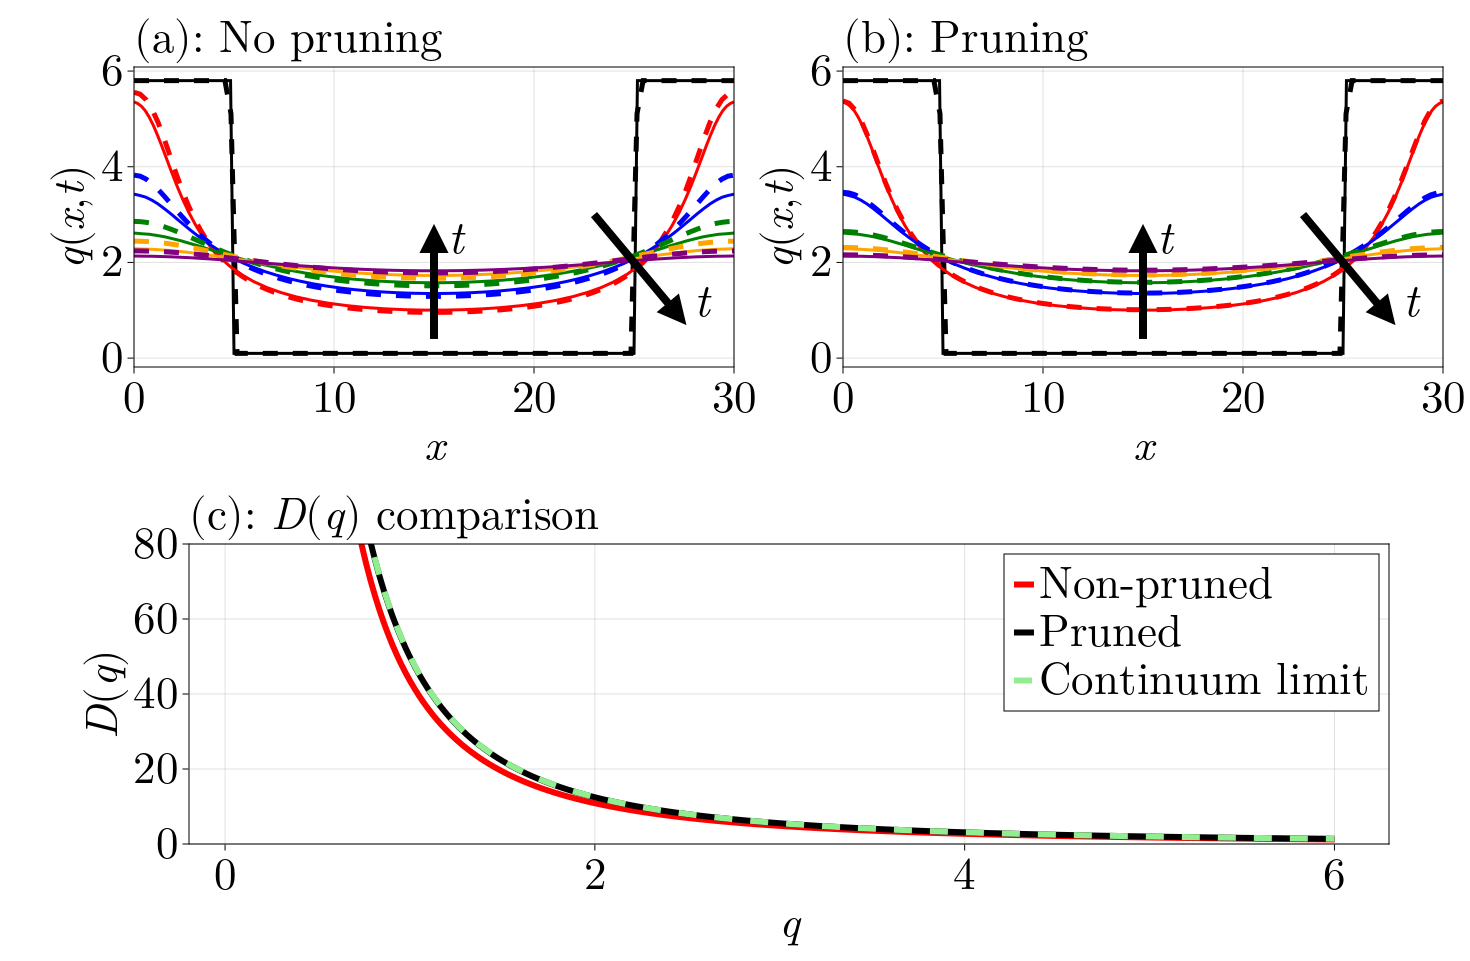

In [11]:
fig = Figure(fontsize=45, resolution=(1470, 961))
ax = Axis(fig[1, 1], xlabel=L"x", ylabel=L"q(x, t)",
    width=600, height=300,
    title=L"(a):$ $ No pruning", titlealign=:left,
    xticks=(0:10:30, [L"%$s" for s in 0:10:30]),
    yticks=(0:2:6, [L"%$s" for s in 0:2:6]))
ax2 = Axis(fig[1, 2], xlabel=L"x", ylabel=L"q(x, t)",
    width=600, height=300,
    title=L"(b):$ $ Pruning", titlealign=:left,
    xticks=(0:10:30, [L"%$s" for s in 0:10:30]),
    yticks=(0:2:6, [L"%$s" for s in 0:2:6]))
t = (0, 1, 2, 3, 4, 5)
colors = (:black, :red, :blue, :green, :orange, :purple)
time_indices = [findlast(≤(τ), sol.t) for τ in t]
for (j, i) in enumerate(time_indices)
    lines!(ax, eql_sol.pde.geometry.mesh_points, eql_sol.pde_sol.u[i], color=colors[j], linestyle=:dash, linewidth=5)
    lines!(ax, sol.u[i], node_densities(sol.u[i]), color=colors[j], linewidth=3)
    lines!(ax2, eql_sol2.pde.geometry.mesh_points, eql_sol2.pde_sol.u[i], color=colors[j], linestyle=:dash, linewidth=5)
    lines!(ax2, sol.u[i], node_densities(sol.u[i]), color=colors[j], linewidth=3, label=L"%$(t[j])")
end
for ax in (ax, ax2)
    arrows!(ax, [15.0, 23.0], [0.4, 3.0], [0.0, 4.0], [2.0, -2.0], color=:black, linewidth=8, arrowsize=40)
    text!(ax, [15.7, 28.0], [2.0, 0.7], text=[L"t", L"t"], color=:black, fontsize=47)
    xlims!(ax, 0, 30)
end
ax3 = Axis(fig[2, 1:2], xlabel=L"q", ylabel=L"D(q)",
    width=1200, height=300,
    title=L"(c): $D(q)$ comparison", titlealign=:left,
    xticks=(0:2:6, [L"%$s" for s in 0:2:6]),
    yticks=(0:20:80, [L"%$s" for s in 0:20:80]))
D_no_prune = diffusion_basis.(q_range, Ref(eql_sol.diffusion_theta), Ref(nothing))
D_prune = diffusion_basis.(q_range, Ref(eql_sol2.diffusion_theta), Ref(nothing))
D_cont_fnc = q -> (force_law_parameters.k / damping_constant) / q^2
D_cont = D_cont_fnc.(q_range)
lines!(ax3, q_range, D_no_prune, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Non-pruned")
lines!(ax3, q_range, D_prune, linewidth=6, color=:black, linestyle=:solid, label=L"$ $Pruned")
lines!(ax3, q_range, D_cont, linewidth=6, color=:lightgreen, linestyle=:dash, label=L"$ $Continuum limit")
axislegend(position=:rt)
ylims!(ax3, 0, 80)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*